#Transfer Learning for Cancer Detection

Installing Required libraries
###Step 1.1- Please refer to the "Technical Requirements" section in the book for the neccessary packages to be installed. Please note that chapter has differnt Pytorch Lightning version and thus diff torch dependancies. Some functions may not work with other versions than what is tested below, so please ensure correct versions.

In [1]:
#install correct package here 
!pip install torch==1.10.0 torchvision==0.11.1 torchtext==0.11.0 torchaudio==0.10.0 --quiet
!pip install pytorch-lightning==1.5.2 --quiet
!pip install opendatasets --upgrade --quiet

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:38tcmalloc: large alloc 1147494400 bytes == 0x22ea000 @  0x7fa6d76c4615 0x592b76 0x4df71e 0x59afff 0x515655 0x549576 0x593fce 0x548ae9 0x51566f 0x549576 0x593fce 0x548ae9 0x5127f1 0x598e3b 0x511f68 0x598e3b 0x511f68 0x598e3b 0x511f68 0x4bc98a 0x532e76 0x594b72 0x515600 0x549576 0x593fce 0x548ae9 0x5127f1 0x549576 0x593fce 0x5118f8 0x593dd7
     |████████████████████████████████| 881.9 MB 19 kB/s 
     |████████████████████████████████| 23.3 MB 1.5 MB/s 
     |████████████████████████████████| 8.0 MB 29.5 MB/s 
     |████████████████████████████████| 2.9 MB 32.4 MB/s 
     |████████████████████████████████| 1.0 MB 5.3 MB/s 
     |████████████████████████████████| 136 kB 45.4 MB/s 
     |████████████████████████████████| 408 kB 44.4 MB/s 
     |████████████████████████████████| 829 kB 26.7 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 1.1 MB 37.4 MB/s 
     |██████

##*Step 1.2 Import the neccessary packages. Please refer to the section, Importing the packages in the book for further details. *

In [2]:
import os
import shutil
import opendatasets as od
import pandas as pd
import numpy as np
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchmetrics.functional import accuracy
from torchvision.models import resnet50



import pytorch_lightning as pl

In [3]:
print("pandas version:",pd.__version__)
print("numpy version:",np.__version__)
#print("seaborn version:",sns.__version__)
print("torch version:",torch.__version__)
print("pytorch ligthening version:",pl.__version__)

pandas version: 1.3.5
numpy version: 1.21.6
torch version: 1.10.0+cu102
pytorch ligthening version: 1.5.2


# **Step 2.1 - Load the dataset- Please refer to the book in section "collecting the dataset" for the proper way to collect the dataset and steps to import it. **

In [ ]:
# Refer to the book Chapter 2 for dowloading cancer dataset


In [5]:
cancer_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
cancer_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:
np.random.seed(0)
train_imgs_orig = os.listdir("histopathologic-cancer-detection/train")
selected_image_list = []
for img in np.random.choice(train_imgs_orig, 10000):
  selected_image_list.append(img)
len(selected_image_list)

10000

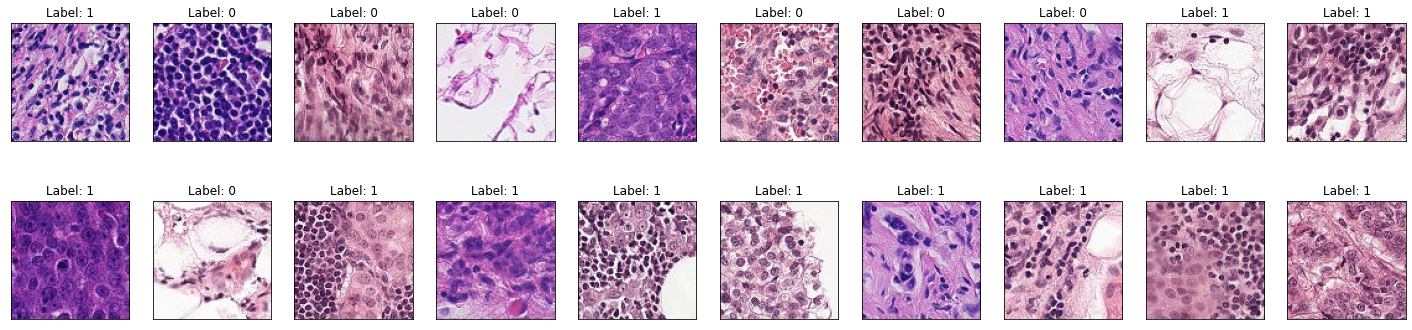

In [7]:
fig = plt.figure(figsize=(25, 6))
for idx, img in enumerate(np.random.choice(selected_image_list, 20)):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    im = Image.open("histopathologic-cancer-detection/train/" + img)
    plt.imshow(im)
    lab = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {lab}')

In [8]:
np.random.seed(0)
np.random.shuffle(selected_image_list)
cancer_train_idx = selected_image_list[:8000]
cancer_test_idx = selected_image_list[8000:]
print("Number of images in the downsampled training dataset: ", len(cancer_train_idx))
print("Number of images in the downsampled testing dataset: ", len(cancer_test_idx))

Number of images in the downsampled training dataset:  8000
Number of images in the downsampled testing dataset:  2000


In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
os.mkdir('/content/gdrive/My Drive/Colab Notebooks/cancer_train_dataset/')
for fname in cancer_train_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cancer_train_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled training dataset: ', len(os.listdir("/content/gdrive/My Drive/Colab Notebooks/cancer_train_dataset/")))


No. of images in downsampled training dataset:  7847


In [11]:
os.mkdir('/content/gdrive/My Drive/Colab Notebooks/cancer_test_dataset/')
for fname in cancer_test_idx:
  src = os.path.join('histopathologic-cancer-detection/train', fname)
  dst = os.path.join('/content/gdrive/My Drive/Colab Notebooks/cancer_test_dataset/', fname)
  shutil.copyfile(src, dst)
print('No. of images in downsampled testing dataset: ', len(os.listdir("/content/gdrive/My Drive/Colab Notebooks/cancer_test_dataset/")))

No. of images in downsampled testing dataset:  1989


In [12]:
selected_image_labels = pd.DataFrame()
id_list = []
label_list = []

for img in selected_image_list:
  label_tuple = cancer_labels.loc[cancer_labels['id'] == img.split('.')[0]]
  id_list.append(label_tuple['id'].values[0])
  label_list.append(label_tuple['label'].values[0])

In [13]:
selected_image_labels['id'] = id_list
selected_image_labels['label'] = label_list
selected_image_labels.head()

,id,label
0,279b48137ef84e2046643570a271f53fff3bfa38,1
1,38e72b91dca852b5f4e09c3493a7d753dda3ce22,1
2,24193085dd15dae0946357ca5b34e563d0e2f80a,1
3,8481bf5669e283bf15973eb9b83accefd17fd035,0
4,43a901a9b28faba70545746e831ca8d71a1972f8,0


In [14]:
img_class_dict = {k:v for k, v in zip(selected_image_labels.id, selected_image_labels.label)}

In [15]:
data_T_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(),
    T.ToTensor()
    ])
data_T_test = T.Compose([
    T.Resize(224),
    T.ToTensor()
    ])

In [16]:
class LoadCancerDataset(Dataset):
    def __init__(self, datafolder, 
                 transform = T.Compose([T.CenterCrop(32),T.ToTensor()]), labels_dict={}):
        self.datafolder = datafolder
        self.image_files_list = [s for s in os.listdir(datafolder)]
        self.transform = transform
        self.labels_dict = labels_dict
        self.labels = [labels_dict[i.split('.')[0]] for i in self.image_files_list]


    def __len__(self):
        return len(self.image_files_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, self.image_files_list[idx])
        image = Image.open(img_name)
        image = self.transform(image)
        img_name_short = self.image_files_list[idx].split('.')[0]

        label = self.labels_dict[img_name_short]
        return image, label

In [17]:
cancer_train_set = LoadCancerDataset(datafolder='/content/gdrive/My Drive/Colab Notebooks/cancer_train_dataset/', 
                        transform=data_T_train, labels_dict=img_class_dict)
cancer_test_set = LoadCancerDataset(datafolder='/content/gdrive/My Drive/Colab Notebooks/cancer_train_dataset/', 
                         transform=data_T_test, labels_dict=img_class_dict)

In [18]:
batch_size = 128

cancer_train_dataloader = DataLoader(cancer_train_set, batch_size, num_workers=2, pin_memory=True, shuffle=True)
cancer_test_dataloader = DataLoader(cancer_test_set, batch_size, num_workers=2, pin_memory=True)

In [19]:
resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
class CancerImageClassifier(pl.LightningModule):

    def __init__(self, learning_rate = 0.001):
        super().__init__()

        self.learning_rate = learning_rate
        self.loss = nn.CrossEntropyLoss()
        
        self.pretrain_model = resnet50(pretrained=True)
        self.pretrain_model.eval()
        for param in self.pretrain_model.parameters():
            param.requires_grad = False

        self.pretrain_model.fc = nn.Linear(2048, 2)

    def forward(self, input):
        output=self.pretrain_model(input)
        return output

    def training_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self(inputs) 
      preds = torch.argmax(outputs, dim=1)
      train_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      self.log('train_accuracy', train_accuracy, prog_bar=True)
      self.log('train_loss', loss)
      return {"loss":loss, 'train_accuracy': train_accuracy}
      

    def test_step(self, batch, batch_idx):
      inputs, targets = batch
      outputs = self.forward(inputs)
      preds = torch.argmax(outputs, dim=1)
      test_accuracy = accuracy(preds, targets)
      loss = self.loss(outputs, targets)
      # self.log('test_accuracy', test_accuracy, prog_bar=True)
      return {"test_loss":loss, "test_accuracy":test_accuracy}
    
    def test_epoch_end(self, outputs):
      test_outs = []
      for test_out in outputs:
          out = test_out['test_accuracy']
          test_outs.append(out)
      total_test_accuracy = torch.stack(test_outs).mean()
      self.log('total_test_accuracy', total_test_accuracy, on_step=False, on_epoch=True)
      return total_test_accuracy

    def configure_optimizers(self):
      params = self.parameters()
      optimizer = optim.Adam(params=params, lr = self.learning_rate)
      return optimizer

In [21]:
model = CancerImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=1)
trainer.fit(model, cancer_train_dataloader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | ResNet           | 23.5 M
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:407: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller tha

Training: 0it [00:00, ?it/s]

In [ ]:
ckpt_dir = "/content/gdrive/MyDrive/Colab Notebooks/transfer_learning"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=10)

model = CancerImageClassifier()
trainer = pl.Trainer(default_root_dir=ckpt_dir, gpus=-1,
                    #  progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=30,
                        max_epochs=10)
trainer.fit(model, train_dataloaders=cancer_train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | loss           | CrossEntropyLoss | 0     
1 | pretrain_model | ResNet           | 23.5 M
----------------------------------------------------
4.1 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.049    Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:111: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."


Training: 0it [00:00, ?it/s]

In [ ]:
trainer.test(test_dataloaders=cancer_test_dataloader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:902: LightningDeprecationWarning: `trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.test(dataloaders)` instead.
  "`trainer.test(test_dataloaders)` is deprecated in v1.4 and will be removed in v1.6."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1394: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.model_checkpoint.last_model_path` to use the last model.
  f"`.{fn}(ckpt_path=None)` was called without a model."
Restoring states from the checkpoint path at /content/gdrive/MyDrive/Colab Notebooks/transfer_learning/lightning_logs/version_0/checkpoints/epoch=9-step=619.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at 

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'total_test_accuracy': 0.8350037336349487}
--------------------------------------------------------------------------------


[{'total_test_accuracy': 0.8350037336349487}]

#### Testing model prediction and calculating accuracy manually 

In [ ]:
model.eval()
preds = []
for batch_i, (data, target) in enumerate(cancer_test_dataloader):
    target = target.cuda()
    output = model(data)

    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)

In [ ]:
test_preds = pd.DataFrame({'imgs': cancer_test_set.image_files_list, 'labels':cancer_test_set.labels,  'preds': preds})
test_preds['imgs'] = test_preds['imgs'].apply(lambda x: x.split('.')[0])
test_preds['predictions'] = 1
test_preds.loc[test_preds['preds'] < 0, 'predictions'] = 0
test_preds.head()


,imgs,labels,preds,predictions
0,3a8338dc8d71cac6bbbf8cb819947f4420cb7960,1,0.927748,1
1,4717e810810ee0d522f5eb814d8fe1428a7a40b5,0,-1.170149,0
2,caaa31ce952d0f09c82f4c4e117e2de4e31c2974,0,-1.726416,0
3,6e491872b06a6b1843baf00b0b00e3064dfb17c3,0,-1.087763,0
4,75e4fc6de9bd6388d022e847207969218ba3709b,0,-1.761306,0


In [ ]:
len(np.where(test_preds['labels'] == test_preds['predictions'])[0])/test_preds.shape[0]

0.8395565184146808